In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from plots import plot2D, plot2DHist

import datetime
import pytz
import simplejson as json

from common import index_lookup
APP_NAME = "Mist-apstat-app"
sc.version


u'1.6.0'

In [2]:
# test dataframe from ap-stats
#

#from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.context import SparkContext
#from pyspark.sql import HiveContext
try:
    from pyspark.sql import SparkSession
except:
    print "old version no SparkSession"

try:
    spark = SparkSession\
        .builder\
        .appName("PythonSQL")\
        .config("spark.some.config.option", "some-value")\
        .getOrCreate()
except:
    pass

print type(sc) == SparkContext



True


# RDD for ap-stats and client-stats

### Dataframe from spark.createDataFrame

In [4]:
def __getAPstats(sc, filename):
    return  sc.sequenceFile(filename).map(lambda kv: kv[1]).map(lambda b:b.decode("utf-8"))


def _apStatsRDD(sc, lasthours=24, topic="ap-stats-staging"):

    backup_store = index_lookup.BackupStore("mist-staging-kafka", "indices")
    current_time = datetime.datetime.utcnow().replace(tzinfo=pytz.utc)
    last_day = current_time - datetime.timedelta(hours=lasthours)
    keys = backup_store.files_between(topic, last_day, current_time)
    file_paths = map(lambda x: x.filePath, keys)
    #print(json.dumps(file_paths))
    print "number of files ", len(file_paths)
    
    apstatsRDD = sc.union(   [__getAPstats(sc, filename)  for filename in file_paths] )

    return apstatsRDD 


def hasClientStats(x):
    if x.get("Clients"):
        return True
    return False

def getClientStats(x):
    #import logging
    #logging.basicConfig(level=logging.DEBUG)
    #log = logging.getLogger("testLog")
    
    output = [] #dict()
    for c in x.get("Clients"):
        tmpDict = c
        tmpDict["SiteID"] = x.get("SiteID")
        tmpDict["OrgID"] = x.get("OrgID")
        tmpDict["ID"] = x.get("ID")
        tmpDict["When"] = x.get("When")
        rindx = c.get("RadioIndex")
        tmpDict.update( x["Radios"][rindx])
        utils = x["Radios"][rindx].get("Utilization", {})
        tmpDict["util_all"] = utils.get("All")
        tmpDict["util_tx"] = utils.get("Tx")
        tmpDict["util_rxinbss"] = utils.get("RxInBSS")
        tmpDict["util_rxotherbss"] = utils.get("RxOtherBSS")
        tmpDict["util_unknownwifi"] = utils.get("UnknownWifi")
        tmpDict["util_nonwifi"] = utils.get("NonWifi")
        #tmpDict["util_"]
        
        #log.info(" testttt {}".format(rindx) )
        
        #c["ttt"]
        #raise ZeroDivisionError(rindx)
        #print rindx
        output.append(tmpDict)
    return output
#hasClientStats(apstatsRDD.first() )

#siteID = '67970e46-4e12-11e6-9188-0242ac110007'
#apID = '5c-5b-35-0e-03-11'
#apstatsRDD = _apStatsRDD(sc, siteID, apID, 2)

apstatsRDD = _apStatsRDD(sc, 2 )

clientStatsRDD = apstatsRDD.map(lambda x: json.loads(x)).filter(hasClientStats).flatMap( getClientStats  )
#clientStatsRDD = apstatsRDD.map(lambda x: json.loads(x)).filter(hasClientStats).flatMap( getClientStats  ) 

print "starting the first event"
print apstatsRDD.first()
print "Ending..."
print clientStatsRDD.first()

Total indices: 8517
s3://mist-staging-kafka/indices/ap-stats-staging/offset=210000000/1_0_00000000000212679794.gz-index.json
start 2016-08-22 16:27:43.100845+00:00
end 2016-08-22 18:27:43.100845+00:00
number of files  7
starting the first event
{
 "Topic": "ap-stats-",
 "HashKey": "5c-5b-35-0e-60-91",
 "Shuffles": [
  {
   "Topic": "ap-client-stats-staging",
   "IterateName": "Clients",
   "KeyName": "MAC",
   "CopyNames": [
    "ID",
    "SiteID",
    "OrgID",
    "MapID",
    "XYZ",
    "When"
   ]
  }
 ],
 "ID": "5c-5b-35-0e-60-91",
 "OrgID": "7e20d5ce-510c-11e5-997e-1258369c38a9",
 "Groups": null,
 "SiteID": "7e21754c-510c-11e5-997e-1258369c38a9",
 "MapID": "9c205ba6-f780-11e5-aa5e-0242ac110006",
 "XYZ": [
  1.292490087145863,
  1.2063240813361389,
  2.3
 ],
 "Uptime": 46988,
 "FirmwareVersion": "0.1.1539-456006c",
 "Configured": true,
 "When": "2016-08-22T16:18:54.376379093Z",
 "Interval": 2.000001154,
 "Proc": {
  "MemInfo": {
   "Total_kB": 515080,
   "Available_kB": 433952
  },

In [7]:
clientStatsRDD1 = (apstatsRDD.map(lambda x: json.loads(x))
                  .filter(lambda b:b.get("ID")=="5c-5b-35-0e-06-e0")
                  .filter(hasClientStats).flatMap( getClientStats  ))

clientStatsRDD2 = (clientStatsRDD1
                   .filter(lambda b: b.get("MAC")== "98-5a-eb-8a-c6-ae")
                   .filter(lambda b: (b.get("InactiveTimeMilliSec")==0)&(b.get("PqMax_used", 0)>1)))
   

/Users/wenfengwang/mistsys/spark-development/_dependencies/spark-2.0.0-bin-hadoop2.7/python/pyspark/sql/session.py:336: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


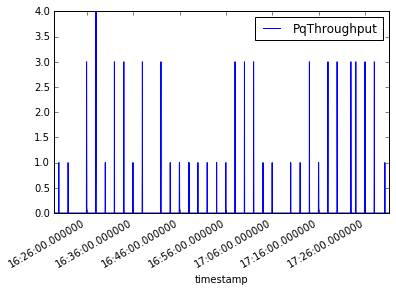

In [30]:
df= spark.createDataFrame(clientStatsRDD1).toPandas()
df.keys()
import pandas as pd

df["timestamp"] = [pd.Timestamp(x)  for x in df["When"]]
df.plot("timestamp", "PqThroughput")

In [24]:
clientStatsRDD_dfs = spark.read.json(clientStatsRDD1)
clientStatsRDD_dfs.registerTempTable("clientStats")

root
 |-- _corrupt_record: string (nullable = true)



In [21]:
clientStatsRDD1.first()

{u'AvgRSSI': -34,
 u'Band': u'2.4',
 u'Bandwidth': 20,
 u'CCKRates': {u'Rx11Mbps': 0,
  u'Rx1Mbps': 4,
  u'Rx2Mbps': 0,
  u'Rx5Mbps': 0,
  u'Tx11Mbps': 0,
  u'Tx11MbpsSucc': 0,
  u'Tx1Mbps': 20,
  u'Tx1MbpsSucc': 17,
  u'Tx2Mbps': 0,
  u'Tx2MbpsSucc': 0,
  u'Tx5Mbps': 0,
  u'Tx5MbpsSucc': 0},
 u'Channel': 1,
 u'ConnectedTimeSec': 1391,
 u'Counter': {u'RxBytes': 62168337,
  u'RxErrors': 21945,
  u'RxMgmt': 32727546,
  u'RxPkts': 488176,
  u'TxBytes': 1483382530,
  u'TxErrors': 12307,
  u'TxMgmt': 19129,
  u'TxPkts': 2724935},
 u'DFS': {u'CacState': 0, u'RadarDetected': False},
 u'Dev': u'r0',
 u'Hostname': u'Wenfengs-MBP-4',
 'ID': u'5c-5b-35-0e-06-e0',
 u'InactiveTimeMilliSec': 22000,
 u'Ipv4': u'10.2.10.210',
 u'MAC': u'98-5a-eb-8a-c6-ae',
 u'MCSRates': {u'MCSType': u'HT',
  u'RxMCS': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  u'RxMCSAmpdu': [4, 0, 0, 1027, 0, 0, 0, 0, 0, 0],
  u'TxMCS': [0, 0, 0, 7, 0, 0, 0, 0, 0, 0],
  u'TxMCSAmpdu': [109, 0, 535, 1510, 0, 0, 0, 0, 0, 8],
  u'TxMCSAmpduSucc'

In [23]:
df1.printSchema()

root
 |-- _corrupt_record: string (nullable = true)



In [ ]:
#df["When"].min(), df["When"].max()
#df[df["PqMax_used"]>200]["Utilization"]
df["util_all"].max()

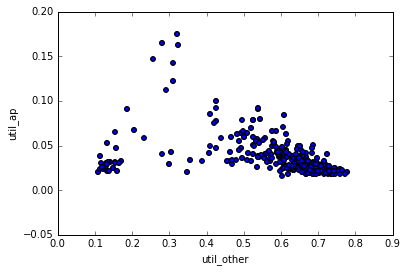

In [32]:

df["util_other"] = 1- df["util_unknownwifi"] - df["util_nonwifi"] - df["util_rxotherbss"]
df["util_ap"] =   df["util_tx"] + df["util_rxinbss"]
                               
df.plot("util_other", "util_ap", kind="scatter")

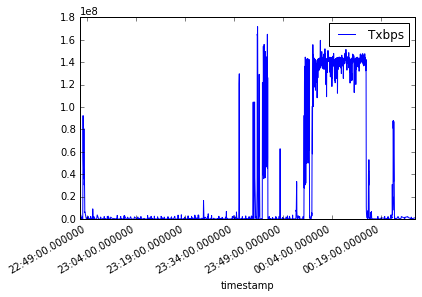

In [94]:
df.plot("timestamp", "Txbps")

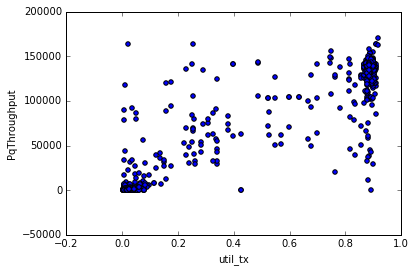

In [96]:
df.plot("util_tx", "PqThroughput", kind="scatter")

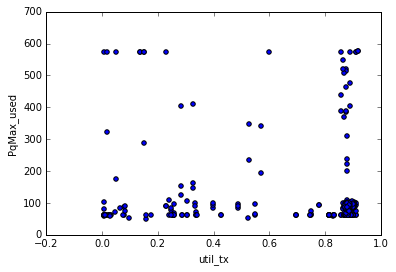

In [100]:
df[df["PqMax_used"]>50].plot("util_tx", "PqMax_used", kind="scatter")

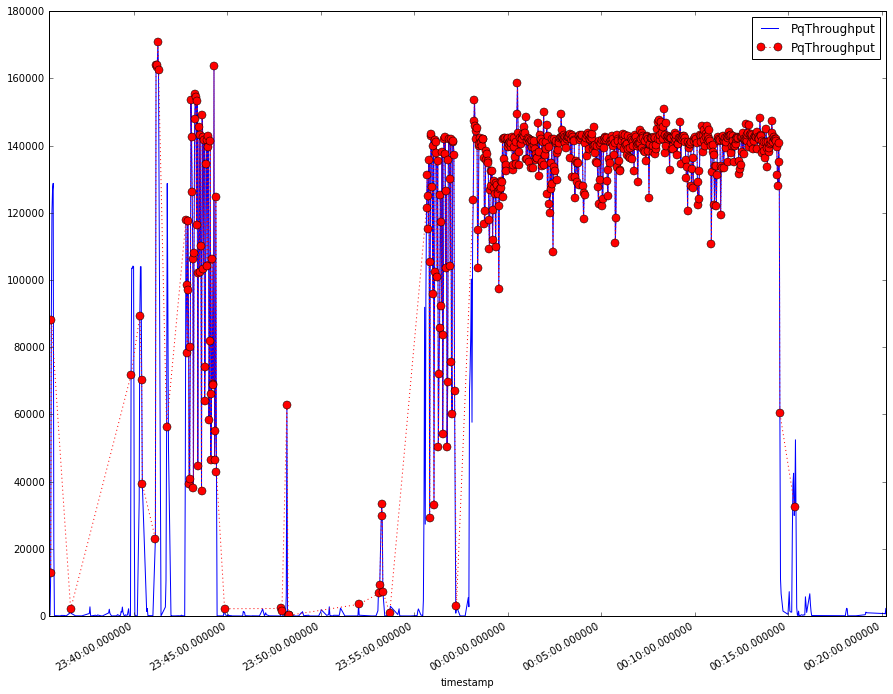

In [105]:
#t1 ='2016-08-19 21:22:17.678961988+0000'
#t2 ='2016-08-19 21:08:17.678961988+0000'
t1 ='2016-08-19 23:35:17.678961988+0000'
t2 ='2016-08-20 00:20:17.678961988+0000'

df1 = df[(df['timestamp']<t2)&(df['timestamp']>t1)]
ax = df1.plot("timestamp", "PqThroughput", figsize=(15, 12))
df1[df1["PqMax_used"]>50].plot("timestamp", "PqThroughput", 
                                color="r", marker = 'o', linestyle=':',markerfacecolor='red', markersize=8,ax=ax)

NameError: name 'df1' is not defined

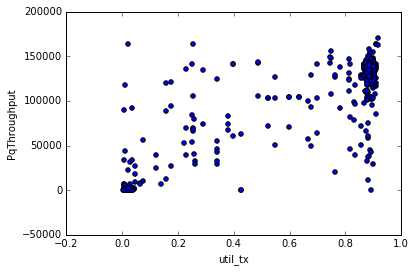

In [107]:
#type(clientStatsRDD2)
#df.corr()
#apstatsRDD.first()
#df1[df1["PqMax_used"]>100][:1]
#df1.plot("util_tx", "PqMax_used", kind="scatter")
df1.plot("util_tx", "PqThroughput", kind="scatter")

In [4]:
#df = clientStatsRDD.toDF()
df = spark.createDataFrame(clientStatsRDD)
df.printSchema()


root
 |-- AvgRSSI: long (nullable = true)
 |-- Band: string (nullable = true)
 |-- Bandwidth: long (nullable = true)
 |-- CCKRates: map (nullable = true)
 |    |-- key: string
 |    |-- value: long (valueContainsNull = true)
 |-- Channel: long (nullable = true)
 |-- ConnectedTimeSec: long (nullable = true)
 |-- Counter: map (nullable = true)
 |    |-- key: string
 |    |-- value: long (valueContainsNull = true)
 |-- DFS: map (nullable = true)
 |    |-- key: string
 |    |-- value: boolean (valueContainsNull = true)
 |-- Dev: string (nullable = true)
 |-- Hostname: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- InactiveTimeMilliSec: long (nullable = true)
 |-- Ipv4: string (nullable = true)
 |-- MAC: string (nullable = true)
 |-- MCSRates: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- MaxTxPower: long (nullable = true)
 |-- NoiseFloor: long (nullable = true)
 |-- OFDMRates: map (nullable = true)
 |    |-- key: string

/Users/wenfengwang/mistsys/spark-development/_dependencies/spark-2.0.0-bin-hadoop2.7/python/pyspark/sql/session.py:336: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


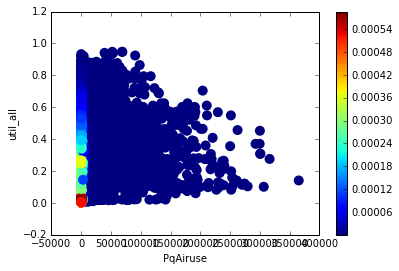

In [11]:
def plotXY(df, xlab="RSSI", ylab="NoiseFloor"):
    xy_data = df.select( xlab, ylab).collect()
    x, y = zip(*xy_data)
    #plt.plot(x, y)
    plot2D(x, y)
    plt.xlabel( xlab )
    plt.ylabel( ylab )
    

#clientStatsRDD.take(1)[0]["Utilization"]
plotXY(df, "PqAiruse", "util_all")

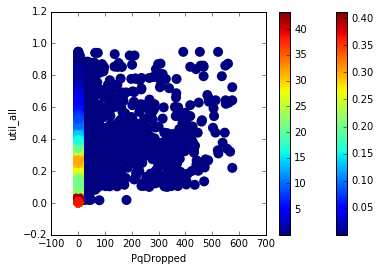

In [23]:
import graphlab as gl

#sf = gl.SFrame.from_rdd(clientStatsRDD, sc)

#rdd = sc.parallelize([1,2,3])
#sf = gl.SFrame.from_rdd(rdd, sc)
cols = ["PqMax_used", "PqLength", "PqDropped"]

#for x in df.printSchema(): print x
#df.select(cols[0]).collect()

plotXY(df, cols[2], "util_all")

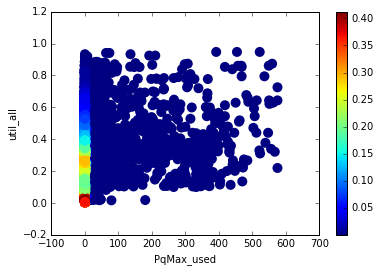

In [24]:
plotXY(df, cols[0], "util_all")

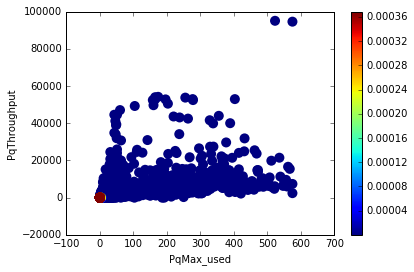

In [25]:
plotXY(df, cols[0], "PqThroughput")

In [31]:
clientStatsRDD1 = clientStatsRDD.filter(lambda b: (b.get("InactiveTimeMilliSec")==0)&(b.get("PqMax_used", 0)>1))
df1 = spark.createDataFrame(clientStatsRDD1)


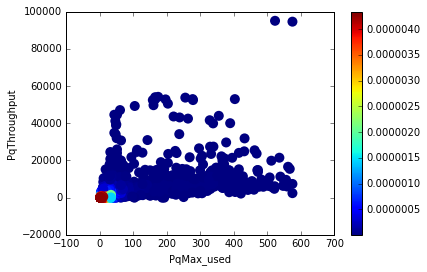

In [32]:

plotXY(df1, cols[0], "PqThroughput")


In [10]:
clientStatsRDD1.take(1)

NameError: name 'clientStatsRDD1' is not defined

# RDD operations





In [ ]:
dir(apstatsRDD)

In [ ]:
# clientStatsRDD.map(lambda b: (b.get("MAC"), 1)).combineByKey(lambda a,b:a+b).collect()


### reduceByKey
 This function operates on RDDs where every element is of the form list(K, V) or c(K, V). and merges the values for each key using an associative reduce function, but return the results immediately to the driver as an R list.


In [ ]:
#df = clientStatsRDD.toDF()
#dir(df)
#type(df.first())
#df1.count(), df.count()
import time
t0 = time.time()
apID = '5c-5b-35-0e-03-11'

#r1 = apstatsRDD.filter(lambda b: b.find(apID)>-1).map(lambda b: (apID, 1)).reduceByKey(lambda a,b:a+b).collect()
#r2 = apstatsRDD.filter(lambda b: b.find(apID)>-1).map(lambda b: (apID, 1)).reduceByKeyLocally(lambda a,b:a+b) #.collect()
r1= clientStatsRDD.map(lambda b: (b.get("MAC"), 1)).reduceByKey(lambda a,b:a+b).collect()
t1 = time.time()

r2= clientStatsRDD.map(lambda b: (b.get("MAC"), 1)).reduceByKeyLocally(lambda a,b:a+b)#.collect()

#r1= clientStatsRDD.map(lambda b: (b.get("MAC"), b.get("Utilization").get("All"))).reduceByKey(lambda a,b:a+b)#.collect()
#r2= clientStatsRDD.map(lambda b: (b.get("MAC"), b.get("Utilization"))).reduceByKeyLocally(lambda a,b:a+b)#.collect()


t2 = time.time()
print t1-t0, t2 - t1
#clientStatsRDD.getNumPartitions()

## reduceByKey Max(), sortByKey()


In [ ]:
clientStatsRDD.map(lambda b: (b.get("MAC"), b.get("Utilization").get("All")))\
              .reduceByKey(lambda a, b: a if a>b else b)\
              .take(5) #collect()


In [ ]:
clientStatsRDD.map(lambda b: (b.get("MAC"), b.get("Utilization").get("All")))\
              .reduceByKey(lambda a, b: a if a>b else b)\
              .sortByKey()\
              .take(5) #collect()


In [ ]:
# sortBy value, descending

clientStatsRDD.map(lambda b: (b.get("MAC"), b.get("Utilization").get("All")))\
              .reduceByKey(lambda a, b: a if a>b else b)\
              .sortBy(lambda x: x[1], False)\
              .take(5) #collect()

# Average 

In [ ]:
%time res = clientStatsRDD.map(lambda b: (b.get("MAC"), ( b.get("Utilization").get("All"), 1) ))\
                    .reduceByKey(lambda a, b: (a[0] + b[0], a[1]+b[1]) )\
                    .take(5) #collect()
        

In [ ]:
for x in res:
    print x[0], x[1][0]/x[1][1]

### Hourly average

In [ ]:
def getMAChour(b):
    mac_hour = "".join( [b.get("MAC"), "_", b.get("When").split(":")[1] ])
    return (mac_hour, ( b.get("Utilization").get("All"), 1) )

%time res = clientStatsRDD.map( getMAChour )\
                    .reduceByKey(lambda a, b: (a[0] + b[0], a[1]+b[1]) )\
                    .sortByKey()\
                    .take(5) #collect()
for x in res:
    print x[0], x[1][0]/x[1][1]

# Spark dataframe SQL


In [ ]:
df = spark.createDataFrame(clientStatsRDD)

In [ ]:
dfg = df.select( df["MAC"], df["Utilization"]["All"]).groupby("MAC") #take(2)#.show()

In [ ]:
#clientStatsRDD.select("MAC")
dir(dfg)
%time dfg.avg().show()

In [ ]:
dir(apstatsRDD)
#

In [ ]:
# RDD sample()

In [ ]:
%time apstatsRDD.count()


In [ ]:
%time apstatsRDD.sample(False, 0.1).count()


In [ ]:
#apstatsRDD.foreachPartition


In [ ]:

def plotXY(df, xlab="RSSI", ylab="NoiseFloor"):
    xy_data = df.select( xlab, ylab).collect()
    x, y = zip(*xy_data)
    #plt.plot(x, y)
    plot2D(x, y)
    plt.xlabel( xlab )
    plt.ylabel( ylab )
    
%time plotXY(df)


In [ ]:
mysite = '67970e46-4e12-11e6-9188-0242ac110007'
myap = '5c:5b:35:0e:03:11'.replace(":", "-")
def plotXY(df, xlab="RSSI", ylab="TxBitRate", mysite='', myap=''):
    
    xy_data = df.filter((df['SiteID']==mysite))\
                .filter(df["ID"]==myap)\
                .filter(df["Band"]=='2.4')\
                .select(xlab, ylab).collect()
    x, y = zip(*xy_data)
    print len(x), len(y)
    #plt.plot(x, y)
    plot2D(x, y)
    plt.xlabel( xlab )
    plt.ylabel( ylab )
    
xlab, ylab="RSSI", "TxBitRate"
%time plotXY(df, xlab, ylab, mysite, myap)


In [ ]:
#apstatsRDD.map(lambda b: sys.getsizeof(b)).first()

xsize = apstatsRDD.map(lambda b: len(b.encode('utf-8')) ).take(2) #collect()
xsize

In [ ]:
import sys
xsize = apstatsRDD.map(lambda b: sys.getsizeof(b) ).collect()
plt.hist(xsize, log=True, bins= 20)

In [ ]:
import numpy as np
print np.mean(xsize)
xsize0= [x for x in xsize]
plt.hist(xsize0, log=True, bins= 20)
plt.xlabel("kb (sys.getsizeof())")

In [ ]:

nclients = apstatsRDD.map(lambda b: json.loads(b) ).map(lambda b: len(b.get("Clients")) if b.get("Clients") else 0).collect() #take(5) #collect()

plt.scatter(nclients, xsize)
plt.xlabel("nclients")
plt.ylabel("Message-size")

In [ ]:
plt.scatter(nclients, xsize)
plt.xlabel("nclients")
plt.ylabel("Message-size")

In [ ]:
x= apstatsRDD.filter(lambda b: sys.getsizeof(b)>400000.).map(lambda b: json.loads(b)).take(3)

In [ ]:
#np.mean(xsize)
np.min(xsize)

In [ ]:
ft =  "s3a://mist-staging-kafka/backups/topics/ap-stats-staging/offset=500000000/1_0_00000000000508733928.gz"
mysite = 'f4d40c28-4aa3-11e5-8510-1258369c38a9'
mysite = '67970e46-4e12-11e6-9188-0242ac110007'
xnum = 2
#mysite = "fa438196-e1ae-11e5-bf9e-1258369c38a9"
def filter_site(kv):
    global mysite
    x = kv[1]
    return x.find(mysite)>-1

    #site_ind1 = x.find('"SiteID":')
    #site_ind2 = x.find(",", site_ind1+10)
    #site_id  = x[site_ind1+11:site_ind2-1]
    ##print site_ind1, site_ind2, site_id, mysite
    #if str(site_id) != str(mysite):
    #    return False
    
    #client_ind1 = x.find('"Clients":') #+ len('"Clients": ')
    #client_ind2 = x.find(",", client_ind1+10)
   
    #print client_ind1, client_ind2, x[client_ind1:client_ind2]
    #if client_ind2 < client_ind1 + 4:
    #    return False
    #return True


rddx = sc.sequenceFile(ft).filter(filter_site)#.map(lambda x: x)
%time rddx.count()

In [ ]:
import sys
from pyspark.sql import SQLContext
from pyspark.context import SparkContext



df = sqlContext.jsonRDD(apstatsRDD)
df.count()

In [ ]:
def _apStatsRDD(sc, siteID = 'ee283a16-cb9f-11e5-84a4-1258369c38a9', apID= '', offset=220000000, filenum="*"):

    path ="".join( ["s3a://mist-staging-kafka/backups/topics/ap-stats-staging/offset=", str(offset), "/", filenum,".gz"])
    print path
    txt = sc.sequenceFile(path)
    
    def isValidJson(x):
        try:
            x.decode()
            return True
        except:
            return False
    
    apstatsRDD = txt.map(lambda kv: kv[1]).filter( isValidJson).map(lambda b: json.loads(b.decode(), 'utf-8'))
    apstatsRDD = apstatsRDD.filter(lambda b:b.get("SiteID")==siteID)
    if apID:
        apstatsRDD = apstatsRDD.filter(lambda b:b.get("ID")==apID)
    
    #messageRDD= messageRDD.map(lambda x: ("ap=" + x.get("ID", ""),
    #                                      x.get("OrgID"), x.get("SiteID"),
    #                                    "when=" + x.get("When"),
    #                                    "clients=" + str( len(x["Clients"]) if x.get("Clients") else 0 ),
    #                                     x.get("Clients"))
    #)
    return apstatsRDD #.take(5)


#siteID = 'f4d40c28-4aa3-11e5-8510-1258369c38a9'
#apID = '5c-5b-35-0e-06-e0' #'5c:5b:35:0e:06:e0' #'98-5a-eb-8a-c6-ae'
#offset = 480000000
#offset, filenum = 490000000, "1_0_00000000000497348254"
#offset, filenum = 490000000, "1_0_0000000000049*" #73*"
#apstatsRDD = _apStatsRDD(sc, siteID, apID, offset, filenum)

#for x in messageRDD.take(5):    print x #[5]#.get("Clients")


In [ ]:
#for x in apstatsRDD.take(2):
#      print x.get("Clients") is not None, len(x.get("Clients"))
apstatsRDD.first()

In [ ]:
apstatsRDD.count()


In [ ]:
import sys
xsize = apstatsRDD.map(lambda b: sys.getsizeof(str(b)) ).collect()
plt.hist(xsize, log=True, bins= 20)

In [ ]:
apstats_large= apstatsRDD.filter(lambda b: sys.getsizeof(str(b))>20000 ).collect()


In [ ]:
sys.getsizeof(str(apstats_large[0] ))
#len(apstats_large)
apstats_large[0]

In [ ]:
#apstats_large[0].get(u'Probes')
apstats_large[0].get("Proc").keys()

In [ ]:
apstats_large[0].get("Proc").get("Raw")

In [ ]:
dir(apstatsRDD)

In [ ]:
apstatsRDD.sample(True, 0.1).count()

In [ ]:
nclients = apstatsRDD.map(lambda x: len(x.get("Clients", [])) ).collect()

In [ ]:
#plt.hist(nclients, log=True, bins= 20)
#nclients

In [ ]:
c1

In [ ]:
#clientStatsRDD.count()
print c1[0].keys()

In [ ]:
clientStatsRDD.map(lambda x: (x.get("MAC"), x.get("RSSI"))).groupByKey().map(lambda x : (x[0], list(x[1]))).take(3)
#clientStatsRDD.map(lambda x: (x.get("MAC"), x.get("RSSI"))).groupByKey().mapValues(list).take(1)


In [ ]:
c1[0].get("Utilization")

In [ ]:


def plotXY(clientStatsRDD, xlab="RSSI", ylab="NoiseFloor"):
    xy_data = clientStatsRDD.map(lambda x: ( x.get(xlab), x.get(ylab))).collect()
    x, y = zip(*xy_data)
    #plt.plot(x, y)
    plot2D(x, y)
    plt.xlabel( xlab )
    plt.ylabel( ylab )
    
%time plotXY(clientStatsRDD)

In [ ]:
plotXY(clientStatsRDD, "RSSI", "TxBitRate")

In [ ]:
    
    #x, y
#xy_data[:3]
from datetime import datetime
from numpy import datetime64
#datetime.strptime( x[0], "%Y-%M-%d" )
#datetime64(x[0])
#x[0]

xlab, ylab = "When", "RSSI"
xy_data = clientStatsRDD.map(lambda x: ( datetime64( x.get(xlab) ), x.get(ylab))).collect()
x, y = zip(*xy_data)
#plt.plot(x, y)

plt.figure(figsize=(15, 10))
plt.plot(x, y)
plt.xlabel( xlab )
plt.ylabel( ylab )


In [ ]:
plotXY(clientStatsRDD, "PqMax_used", "PqRetried")

In [ ]:
def plotXY_utilization(clientStatsRDD, xlab="RSSI", ylab="All"):
    xy_data = clientStatsRDD.map(lambda x: ( x.get(xlab),  x["Utilization"].get(ylab) )).collect()
    x, y = zip(*xy_data)
    #plt.plot(x, y)
    plot2D(x, y)
    plt.xlabel( xlab )
    plt.ylabel( "utilizatio_"+ylab )
    
plotXY_utilization(clientStatsRDD)

In [ ]:
plotXY_utilization(clientStatsRDD,  u'PqThroughput', "Tx")


In [ ]:
def plotXY_utilization(clientStatsRDD, xlab="RSS", ylab="All"):
    xy_data = clientStatsRDD.map(lambda x: ( x.get(xlab),  x["Utilization"].get(ylab) )).collect()
    x, y = zip(*xy_data)
    #plt.plot(x, y)
    plot2D(x, y)
    plt.xlabel( xlab )
    plt.ylabel( "utilizatio_"+ylab )
    
plotXY_utilization(clientStatsRDD, "PqRetried", "Tx")

In [ ]:
plotXY_utilization(clientStatsRDD, "PqRtsfail", "Tx")

In [ ]:
#df = sqlContext.table("clientStats")
#clientStatsRDD.registerTempTable('clientStatsTable')
#sqlContext.sql("SELECT * FROM clientStatsTable")    
sqlContext.table("")

In [ ]:
from sklearn import grid_search, datasets
from sklearn.ensemble import RandomForestClassifier
# Use spark_sklearn’s grid search instead:
from spark_sklearn import GridSearchCV
digits = datasets.load_digits()
X, y = digits.data, digits.target
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_estimators": [10, 20, 40, 80]}
gs = grid_search.GridSearchCV(RandomForestClassifier(),
param_grid=param_grid)
gs.fit(X, y)